In [1]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchsde 
import torch.nn.utils as utils
import matplotlib.pyplot as plt
import random
import datetime
import warnings
warnings.filterwarnings('ignore')
# Set random seed
seed = 42
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
print(f"Using random seed: {seed}")
# --- Configuration ---
ASSET_1 = 'TRY=X'
ASSET_2 = 'USDT-USD'

START_DATE = '2017-04-01'
END_DATE = '2025-07-24'
LOOKBACK = 44
TIME_STEP = 1
BATCH_SIZE = 256
TRAIN_SPLIT = 0.65
EPOCHS = 40
HIDDEN_SIZE = 1024
INPUT_FEATURES = 2
OUTPUT_SIZE = 1
LEARNING_RATE = 1e-5

# --- Preprocessing ---
def preprocess_data(df, lookback, time_step, batch_size=64, split_ratio=0.65):
    features = df[['Asset1', 'Asset2']].values
    targets = df['Asset2'].values

    X_raw, y_raw = [], []
    for i in range(len(features) - lookback - time_step):
        X_raw.append(features[i:i+lookback])
        y_raw.append(targets[i+lookback+time_step])

    X_raw, y_raw = np.array(X_raw), np.array(y_raw).reshape(-1, 1)
    total_len = len(X_raw)
    train_idx = int(split_ratio * total_len)
    val_idx = int((split_ratio + (1 - split_ratio)/2) * total_len)

    X_train_raw = X_raw[:train_idx]
    y_train_raw = y_raw[:train_idx]
    X_val_raw = X_raw[train_idx:val_idx]
    y_val_raw = y_raw[train_idx:val_idx]
    X_test_raw = X_raw[val_idx:]
    y_test_raw = y_raw[val_idx:]

    feat_scaler = MinMaxScaler()
    tgt_scaler = MinMaxScaler()

    X_train = feat_scaler.fit_transform(X_train_raw.reshape(-1, features.shape[1])).reshape(X_train_raw.shape)
    X_val = feat_scaler.transform(X_val_raw.reshape(-1, features.shape[1])).reshape(X_val_raw.shape)
    X_test = feat_scaler.transform(X_test_raw.reshape(-1, features.shape[1])).reshape(X_test_raw.shape)

    y_train = tgt_scaler.fit_transform(y_train_raw)
    y_val = tgt_scaler.transform(y_val_raw)
    y_test = tgt_scaler.transform(y_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, X_test

# --- Load Data ---
def load_combined_minute_data(asset1, asset2, total_days=8, interval='1m'):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=total_days)
    dfs1, dfs2 = [], []
    window = total_days  # yfinance max for minute data

    for i in range(0, total_days, window):
        win_start = start_date + datetime.timedelta(days=i)
        win_end = min(win_start + datetime.timedelta(days=window), end_date)
        # yfinance expects string dates
        win_start_str = win_start.strftime('%Y-%m-%d')
        win_end_str = win_end.strftime('%Y-%m-%d')
        df1 = yf.download(asset1, start=win_start_str, end=win_end_str, interval=interval, progress=False)['Close']
        df2 = yf.download(asset2, start=win_start_str, end=win_end_str, interval=interval, progress=False)['Close']
        dfs1.append(df1)
        dfs2.append(df2)

    data1 = pd.concat(dfs1)
    data2 = pd.concat(dfs2)
    combined = pd.concat([data1, data2], axis=1).dropna()
    combined.columns = ['Asset1', 'Asset2']
    return combined

# --- Model ---
class NeuralSDEWithJump(nn.Module):
    def __init__(self, hidden_size, input_features, output_size, lookback):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.lookback = lookback

        self.drift_lstm = nn.LSTM(input_features, hidden_size, batch_first=True)
        self.diffusion_lstm = nn.LSTM(input_features, hidden_size, batch_first=True)

        self.drift_linear = nn.Linear(hidden_size + output_size, output_size)
        self.diffusion_linear = nn.Linear(hidden_size + output_size, output_size)

        self.jump_intensity = 0.000005
        self.jump_mean = 0.0
        self.jump_std = 0.05
        self._lstm_hidden_buffer = None

    def f(self, t, y):
        if self._lstm_hidden_buffer is None:
            raise RuntimeError("LSTM hidden state not set.")
        combined = torch.cat((self._lstm_hidden_buffer, y), dim=1)
        return self.drift_linear(combined)

    def g(self, t, y):
        if self._lstm_hidden_buffer is None:
            raise RuntimeError("LSTM hidden state not set.")
        combined = torch.cat((self._lstm_hidden_buffer, y), dim=1)
        return self.diffusion_linear(combined)

    def jump(self, t, y):
        jump_prob = self.jump_intensity * 0.01
        jump_occurred = torch.bernoulli(torch.full_like(y, jump_prob))
        jump_noise = torch.randn_like(y) * self.jump_std + self.jump_mean
        return jump_occurred * jump_noise

    def forward(self, ts, y0, input_seq):
        lstm_output, (hidden, _) = self.drift_lstm(input_seq)
        self._lstm_hidden_buffer = hidden.squeeze(0)

        y = y0
        ys = [y0]
        dt = ts[1] - ts[0]

        for t in ts[1:]:
            drift = self.f(t, y)
            diffusion = self.g(t, y)
            brownian = torch.randn_like(y) * torch.sqrt(dt)
            jump = self.jump(t, y)
            y = y + drift * dt + diffusion * brownian + jump
            ys.append(y)

        ys = torch.stack(ys)
        self._lstm_hidden_buffer = None
        return ys

# --- Training ---
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    model.train()
    val_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            y0 = inputs[:, 0, 1].unsqueeze(1)
            ts = torch.tensor([0.0, 1.0], device=device)
            solutions = model(ts, y0, inputs)
            preds = solutions[-1]
            loss = criterion(preds, targets)
            loss.backward()
            utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                y0 = val_inputs[:, 0, 1].unsqueeze(1)
                ts = torch.tensor([0.0, 1.0], device=device)
                val_preds = model(ts, y0, val_inputs)[-1]
                val_loss += criterion(val_preds, val_targets).item()
        model.train()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    return val_losses

# --- Evaluation ---
def evaluate_model(model, test_loader, target_scaler, device, lookback):
    model.eval()
    actual, predicted = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            y0 = inputs[:, 0, 1].unsqueeze(1)
            ts = torch.tensor([0.0, 1.0], device=device)
            solutions = model(ts, y0, inputs)
            preds = solutions[-1]
            actual.append(targets.squeeze().detach().cpu().numpy())
            predicted.append(preds.squeeze().detach().cpu().numpy())
    actual = np.concatenate(actual)
    predicted = np.concatenate(predicted)
    actual_orig = target_scaler.inverse_transform(actual.reshape(-1, 1))
    predicted_orig = target_scaler.inverse_transform(predicted.reshape(-1, 1))
    shifted_pred = predicted_orig[:-lookback]
    actual_aligned = actual_orig[lookback:]
    return actual_aligned, shifted_pred

def plot_results(actual, predicted, lookback):
    plt.figure(figsize=(14, 7))
    plt.plot(actual, label='Actual Asset 2')
    plt.plot(predicted, label=f'Predicted Asset 2 (shift={lookback})')
    plt.title('Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"Test RMSE: {rmse:.4f}")

# --- Validation Loss Plot ---
def plot_val_loss(val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Validation Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

# --- Shock Simulation ---
def simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, lookback, device, std_multiplier=-2):
    model.eval()
    window = combined_data[['Asset1', 'Asset2']].values[-lookback:].copy()
    asset1_std = combined_data['Asset1'].std()
    shocked_value = window[-1, 0] + std_multiplier * asset1_std
    # print(f"Original Asset1: {window[-1, 0]:.2f}, Shocked: {shocked_value:.2f}")
    window[-1, 0] = shocked_value
    window_scaled = feat_scaler.transform(window)
    input_tensor = torch.tensor(window_scaled, dtype=torch.float32).unsqueeze(0).to(device)
    y0 = input_tensor[:, 0, 1].unsqueeze(1)
    ts = torch.tensor([0.0, 1.0], device=device)
    with torch.no_grad():
        output = model(ts, y0, input_tensor)
        predicted_scaled = output[-1].cpu().numpy().reshape(-1, 1)
        predicted = tgt_scaler.inverse_transform(predicted_scaled)
    # print(f"Predicted Asset2 after shock: {predicted[0][0]:.4f}")
    return predicted[0][0]

# --- Main Execution ---
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    combined_data = load_combined_minute_data(ASSET_1, ASSET_2, total_days=8, interval='1m')
    train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, _ = preprocess_data(
        combined_data, LOOKBACK, TIME_STEP, BATCH_SIZE, TRAIN_SPLIT
    )

    model = NeuralSDEWithJump(HIDDEN_SIZE, INPUT_FEATURES, OUTPUT_SIZE, LOOKBACK).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS)
    plot_val_loss(val_losses)

    actual, predicted = evaluate_model(model, test_loader, tgt_scaler, device, lookback=LOOKBACK)
    plot_results(actual, predicted, lookback=1)

    print("Simulating shock...")
    simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=-2)
    simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=4)
    print("Done.")

# Run
# if __name__ == "__main__":
#     main()
# simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=-2)
# simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=4)

Using random seed: 42


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

combined_data = load_combined_minute_data(ASSET_1, ASSET_2, total_days=8*365, interval='1d')
train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, _ = preprocess_data(
combined_data, LOOKBACK, TIME_STEP, BATCH_SIZE, TRAIN_SPLIT
)

Using device: cuda


In [3]:
# --- Wavelet Denoising Preprocessing ---
import pywt

def wavelet_denoise(series, wavelet='db4', level=1):
    coeffs = pywt.wavedec(series, wavelet, level=level)
    coeffs[1:] = [pywt.threshold(c, value=0.5*np.std(c), mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

# Apply denoising to CL=F and NG=F columns in combined_data
denoised_asset1 = wavelet_denoise(combined_data['Asset1'].values)
denoised_asset2 = wavelet_denoise(combined_data['Asset2'].values)

combined_data_denoised = combined_data.copy()
combined_data_denoised['Asset1'] = denoised_asset1
combined_data_denoised['Asset2'] = denoised_asset2

# Use denoised data for training
train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, _ = preprocess_data(
    combined_data_denoised, LOOKBACK, TIME_STEP, BATCH_SIZE, TRAIN_SPLIT
)

Epoch 1/40, Train Loss: 0.0122, Val Loss: 0.0049
Epoch 2/40, Train Loss: 0.0124, Val Loss: 0.0037
Epoch 3/40, Train Loss: 0.0098, Val Loss: 0.0027
Epoch 4/40, Train Loss: 0.0089, Val Loss: 0.0018
Epoch 5/40, Train Loss: 0.0081, Val Loss: 0.0012
Epoch 4/40, Train Loss: 0.0089, Val Loss: 0.0018
Epoch 5/40, Train Loss: 0.0081, Val Loss: 0.0012
Epoch 6/40, Train Loss: 0.0078, Val Loss: 0.0008
Epoch 7/40, Train Loss: 0.0080, Val Loss: 0.0005
Epoch 6/40, Train Loss: 0.0078, Val Loss: 0.0008
Epoch 7/40, Train Loss: 0.0080, Val Loss: 0.0005
Epoch 8/40, Train Loss: 0.0070, Val Loss: 0.0003
Epoch 9/40, Train Loss: 0.0066, Val Loss: 0.0002
Epoch 8/40, Train Loss: 0.0070, Val Loss: 0.0003
Epoch 9/40, Train Loss: 0.0066, Val Loss: 0.0002
Epoch 10/40, Train Loss: 0.0081, Val Loss: 0.0001
Epoch 11/40, Train Loss: 0.0061, Val Loss: 0.0002
Epoch 10/40, Train Loss: 0.0081, Val Loss: 0.0001
Epoch 11/40, Train Loss: 0.0061, Val Loss: 0.0002
Epoch 12/40, Train Loss: 0.0060, Val Loss: 0.0002
Epoch 13/40, Tr

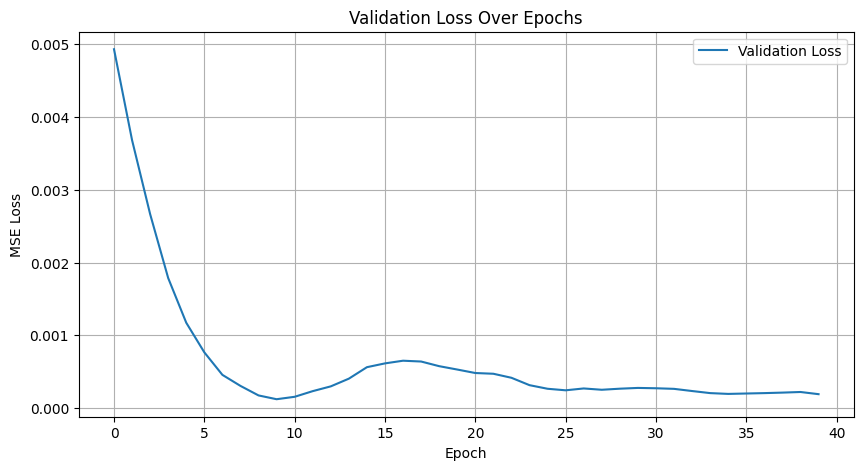

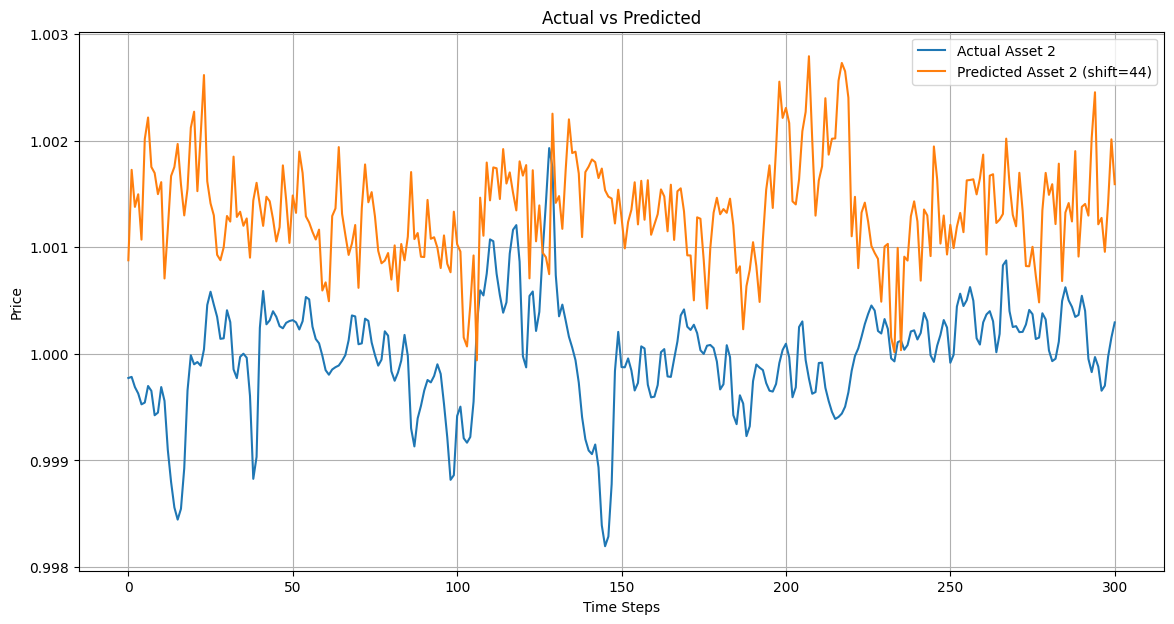

Test RMSE: 0.0015
Simulating shock...
Done.


In [4]:
model = NeuralSDEWithJump(HIDDEN_SIZE, INPUT_FEATURES, OUTPUT_SIZE, LOOKBACK).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, 40)
plot_val_loss(val_losses)

actual, predicted = evaluate_model(model, test_loader, tgt_scaler, device, lookback=LOOKBACK)
plot_results(actual, predicted, lookback=LOOKBACK)

print("Simulating shock...")
simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=-2)
simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=4)
print("Done.")

In [5]:
import pandas as pd
import numpy as np

shock_range = range(-10, 11)
n_iter = 1000
all_results = {std: [] for std in shock_range}

for i in range(n_iter):
    base_pred = simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=0)
    for std_mult in shock_range:
        pred = simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=std_mult)
        diff = pred - base_pred
        all_results[std_mult].append((pred, diff))     


avg_results = []
for std_mult in shock_range:
    preds, diffs = zip(*all_results[std_mult])
    avg_pred = np.mean(preds)
    avg_diff = np.mean(diffs)
    avg_results.append({'Std_Deviation': std_mult, 'Avg_Predicted_Price': avg_pred, 'Avg_Difference_vs_No_Shock': avg_diff})

avg_shock_df = pd.DataFrame(avg_results)
print(avg_shock_df.to_string(index=False))

 Std_Deviation  Avg_Predicted_Price  Avg_Difference_vs_No_Shock
           -10             1.000099                   -0.001964
            -9             1.000308                   -0.001755
            -8             1.000522                   -0.001541
            -7             1.000729                   -0.001334
            -6             1.000934                   -0.001128
            -5             1.001130                   -0.000932
            -4             1.001322                   -0.000741
            -3             1.001511                   -0.000552
            -2             1.001685                   -0.000377
            -1             1.001870                   -0.000192
             0             1.002034                   -0.000028
             1             1.002207                    0.000145
             2             1.002373                    0.000311
             3             1.002525                    0.000462
             4             1.002681     

Epoch 1/100, Train Loss: 0.0426, Val Loss: 0.1445
Epoch 2/100, Train Loss: 0.0405, Val Loss: 0.1452
Epoch 3/100, Train Loss: 0.0387, Val Loss: 0.1460
Epoch 4/100, Train Loss: 0.0377, Val Loss: 0.1470
Epoch 3/100, Train Loss: 0.0387, Val Loss: 0.1460
Epoch 4/100, Train Loss: 0.0377, Val Loss: 0.1470
Epoch 5/100, Train Loss: 0.0419, Val Loss: 0.1473
Epoch 6/100, Train Loss: 0.0352, Val Loss: 0.1480
Epoch 5/100, Train Loss: 0.0419, Val Loss: 0.1473
Epoch 6/100, Train Loss: 0.0352, Val Loss: 0.1480
Epoch 7/100, Train Loss: 0.0368, Val Loss: 0.1481
Epoch 8/100, Train Loss: 0.0359, Val Loss: 0.1476
Epoch 7/100, Train Loss: 0.0368, Val Loss: 0.1481
Epoch 8/100, Train Loss: 0.0359, Val Loss: 0.1476
Epoch 9/100, Train Loss: 0.0369, Val Loss: 0.1475
Epoch 10/100, Train Loss: 0.0358, Val Loss: 0.1474
Epoch 9/100, Train Loss: 0.0369, Val Loss: 0.1475
Epoch 10/100, Train Loss: 0.0358, Val Loss: 0.1474
Epoch 11/100, Train Loss: 0.0391, Val Loss: 0.1470
Epoch 12/100, Train Loss: 0.0388, Val Loss: 0.1

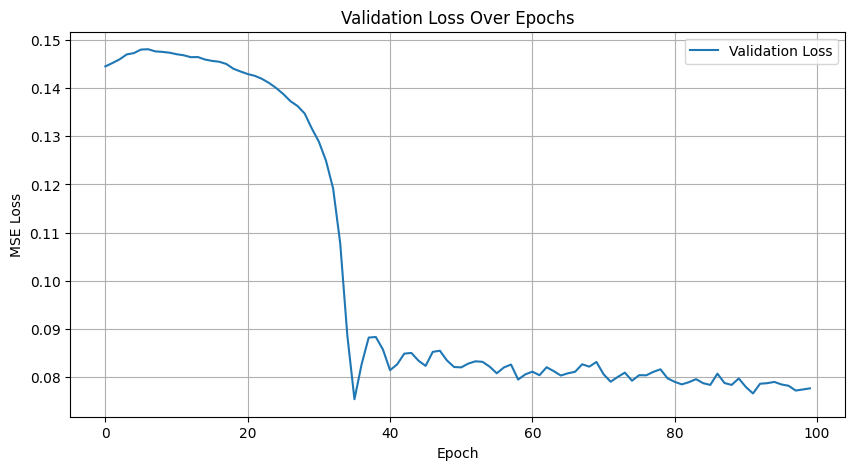

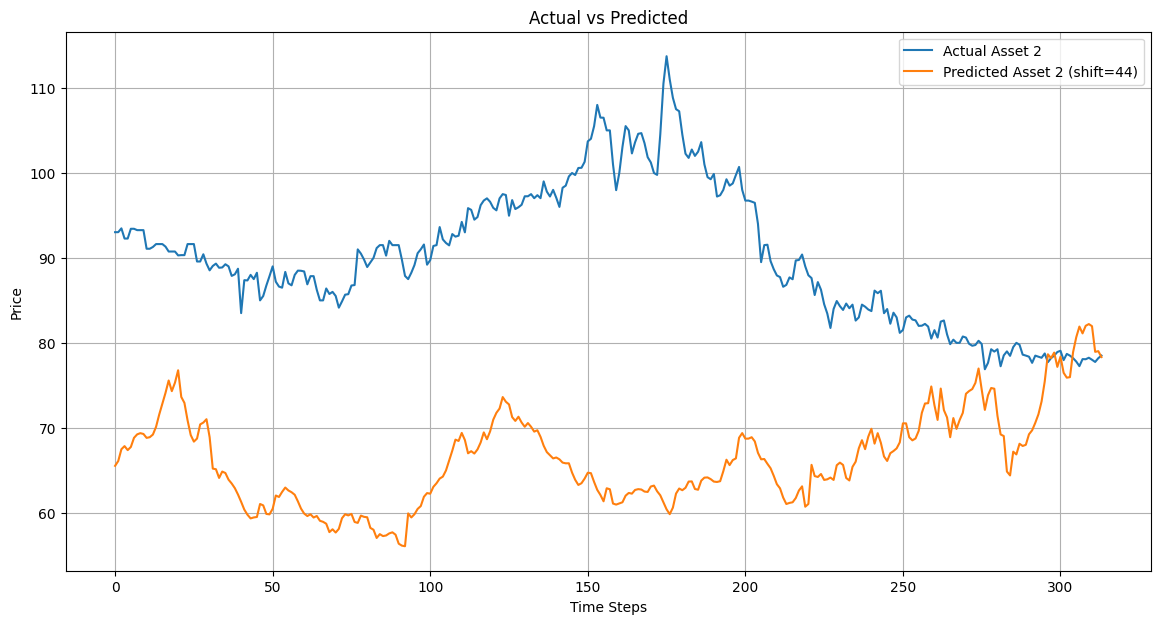

Test RMSE: 26.3662
Linear Regression coefficients:
  Neural SDE prediction: -0.4727
  CL=F: 0.2318
  Intercept: 104.9875
Linear Regression RMSE: 7.2634
Linear Regression coefficients:
  Neural SDE prediction: -0.4727
  CL=F: 0.2318
  Intercept: 104.9875
Linear Regression RMSE: 7.2634


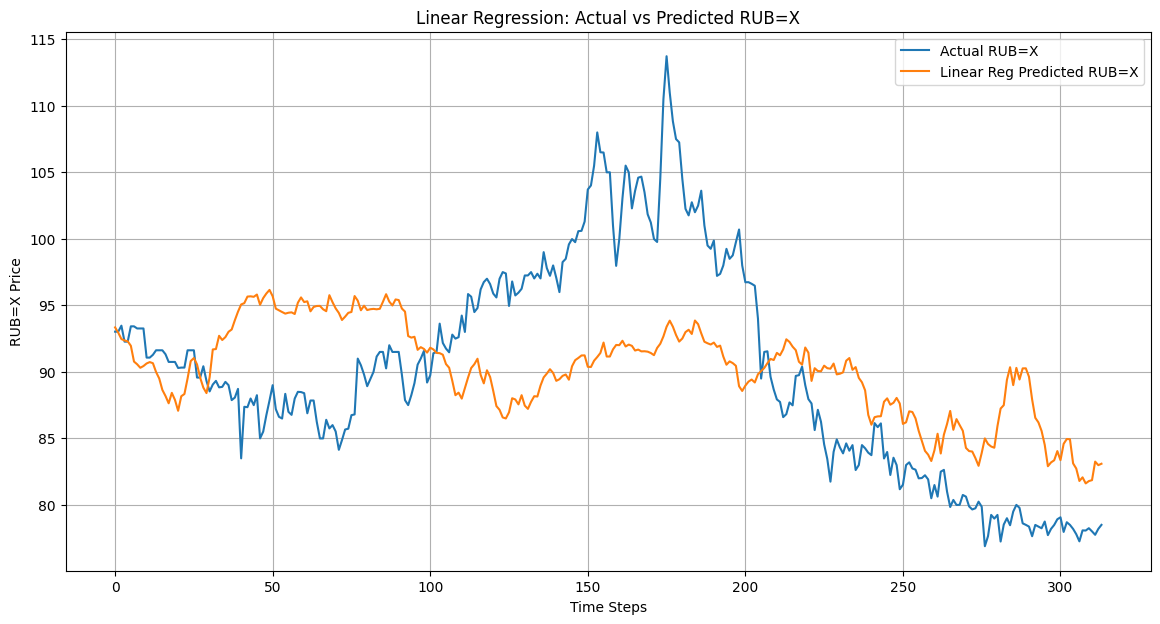

Second Linear Regression coefficients:
  Previous regression prediction: 0.0000
  CL=F: -0.0000
  Intercept: 1.0000
Second Linear Regression RMSE: 0.0006


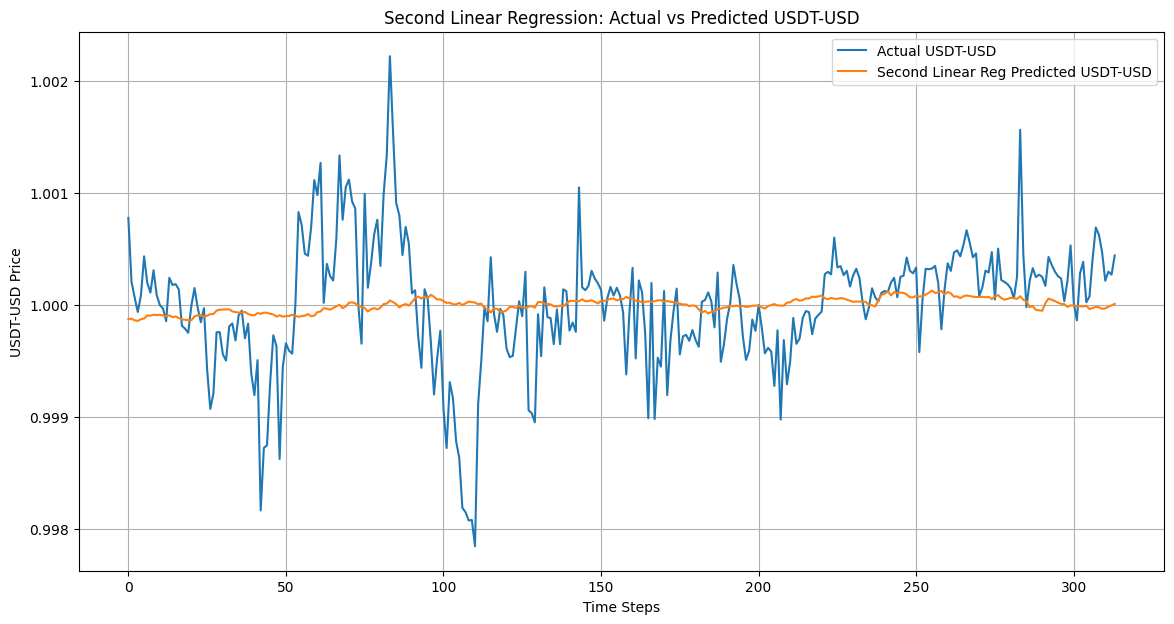

                 Model Comparison                 
                                OLS             IV
--------------------------------------------------
Dep. Variable              usdt_usd       usdt_usd
Estimator                       OLS        IV-2SLS
No. Observations                314            314
Cov. Est.                    robust         robust
R-squared                    0.0811        -0.0844
Adj. R-squared               0.0751        -0.0914
F-statistic                  76.996         5.4360
P-value (F-stat)             0.0000         0.0660
==================     ============   ============
Intercept                    1.0018         1.0000
                           (3709.8)       (1062.8)
rub_actual               -1.956e-05      1.028e-05
                          (-6.2424)       (0.7771)
cl                       -1.092e-06     -1.332e-05
                          (-0.2030)      (-2.1513)
==================== ============== ==============
Instruments                    

In [6]:
# --- Neural SDE: Predict RUB=X using CL=F and NG=F with Wavelet Denoising ---
import yfinance as yf
import pywt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

# Download data for CL=F, NG=F, RUB=X
start_date = '2017-04-01'
end_date = '2025-07-24'
### CL=F, NG=F, IMOEX, RTSI,
df_cl = yf.download('CL=F', start=start_date, end=end_date, interval='1d', progress=False)[['Close']].rename(columns={'Close': 'CL=F'})
df_ng = yf.download('NG=F', start=start_date, end=end_date, interval='1d', progress=False)[['Close']].rename(columns={'Close': 'NG=F'})
df_rub = yf.download('RUB=X', start=start_date, end=end_date, interval='1d', progress=False)[['Close']].rename(columns={'Close': 'RUB=X'})

# Merge and drop missing values
df = pd.concat([df_cl, df_ng, df_rub], axis=1).dropna()

# Wavelet denoising function (always returns 1D array)
def wavelet_denoise(series, wavelet='db4', level=1):
    series = np.asarray(series).flatten()
    coeffs = pywt.wavedec(series, wavelet, level=level)
    coeffs[1:] = [pywt.threshold(c, value=0.5*np.std(c), mode='soft') for c in coeffs[1:]]
    rec = pywt.waverec(coeffs, wavelet)
    return rec[:len(series)]  # Ensure same length, 1D

# Apply denoising to CL=F and NG=F (ensure 1D assignment)
df['CL=F_denoised'] = wavelet_denoise(df['CL=F'].values.reshape(-1)).reshape(-1)
df['NG=F_denoised'] = wavelet_denoise(df['NG=F'].values.reshape(-1)).reshape(-1)

# Prepare DataFrame for model (ensure all columns are 1D)
model_df = pd.DataFrame({
    'Asset1': df['CL=F_denoised'].values.ravel(),
    'Asset2': df['NG=F_denoised'].values.ravel(),
    'Target': df['RUB=X'].values.ravel()
}).dropna()

# Preprocessing for Neural SDE
def preprocess_for_sde(df, lookback, time_step, batch_size=256, split_ratio=0.65):
    features = df[['Asset1', 'Asset2']].values
    targets = df['Target'].values
    X_raw, y_raw = [], []
    for i in range(len(features) - lookback - time_step):
        X_raw.append(features[i:i+lookback])
        y_raw.append(targets[i+lookback+time_step])
    X_raw, y_raw = np.array(X_raw), np.array(y_raw).reshape(-1, 1)
    total_len = len(X_raw)
    train_idx = int(split_ratio * total_len)
    val_idx = int((split_ratio + (1 - split_ratio)/2) * total_len)
    X_train_raw = X_raw[:train_idx]
    y_train_raw = y_raw[:train_idx]
    X_val_raw = X_raw[train_idx:val_idx]
    y_val_raw = y_raw[train_idx:val_idx]
    X_test_raw = X_raw[val_idx:]
    y_test_raw = y_raw[val_idx:]
    feat_scaler = MinMaxScaler()
    tgt_scaler = MinMaxScaler()
    X_train = feat_scaler.fit_transform(X_train_raw.reshape(-1, 2)).reshape(X_train_raw.shape)
    X_val = feat_scaler.transform(X_val_raw.reshape(-1, 2)).reshape(X_val_raw.shape)
    X_test = feat_scaler.transform(X_test_raw.reshape(-1, 2)).reshape(X_test_raw.shape)
    y_train = tgt_scaler.fit_transform(y_train_raw)
    y_val = tgt_scaler.transform(y_val_raw)
    y_test = tgt_scaler.transform(y_test_raw)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, X_test

LOOKBACK = 44
TIME_STEP = 1
BATCH_SIZE = 256
TRAIN_SPLIT = 0.65
EPOCHS = 100
HIDDEN_SIZE = 1024
LEARNING_RATE = 1e-5

train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, X_test = preprocess_for_sde(
    model_df, LOOKBACK, TIME_STEP, BATCH_SIZE, TRAIN_SPLIT
)

# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralSDEWithJump(HIDDEN_SIZE, 2, 1, LOOKBACK).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train model
val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS)
plot_val_loss(val_losses)

# Evaluate model
actual, predicted = evaluate_model(model, test_loader, tgt_scaler, device, lookback=LOOKBACK)
plot_results(actual, predicted, lookback=LOOKBACK)
# --- Linear Regression: Orthogonalize Neural SDE predictions with CL=F to predict RUB=X ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Use the same test set as the Neural SDE evaluation
# actual: true RUB=X prices (already inverse transformed and aligned)
### Everything except CL=F and predictions from Neural SDE
cl_prices = df['CL=F'].values[-len(actual):]  # align CL=F with test set length
X_reg = np.column_stack([predicted, cl_prices])
y_reg = actual

# Fit linear regression
reg = LinearRegression()
reg.fit(X_reg, y_reg)
y_pred_reg = reg.predict(X_reg)

print('Linear Regression coefficients:')
coef_flat = np.ravel(reg.coef_)
print(f'  Neural SDE prediction: {coef_flat[0]:.4f}')
print(f'  CL=F: {coef_flat[1]:.4f}')
intercept_scalar = reg.intercept_[0] if hasattr(reg.intercept_, '__iter__') and not isinstance(reg.intercept_, str) else reg.intercept_
print(f'  Intercept: {intercept_scalar:.4f}')

rmse_reg = np.sqrt(mean_squared_error(y_reg, y_pred_reg))
print(f'Linear Regression RMSE: {rmse_reg:.4f}')

plt.figure(figsize=(14, 7))
plt.plot(y_reg, label='Actual RUB=X')
plt.plot(y_pred_reg, label='Linear Reg Predicted RUB=X')
plt.title('Linear Regression: Actual vs Predicted RUB=X')
plt.xlabel('Time Steps')
plt.ylabel('RUB=X Price')
plt.legend()
plt.grid(True)
plt.show()
# --- Second Linear Regression: Use previous regression predictions to predict USDT-USD prices ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Download USDT-USD prices for the same period as the test set
usdt = yf.download('USDT-USD', start=start_date, end=end_date, interval='1d', progress=False)[['Close']].rename(columns={'Close': 'USDT-USD'})

usdt_prices = usdt['USDT-USD'].values[-len(y_pred_reg):]

# Prepare features: use previous regression predictions (y_pred_reg) and optionally CL=F or other features
X_reg2 = np.column_stack([y_pred_reg, cl_prices])
y_reg2 = usdt_prices

# Fit second linear regression
reg2 = LinearRegression()
reg2.fit(X_reg2, y_reg2)
y_pred_reg2 = reg2.predict(X_reg2)

print('Second Linear Regression coefficients:')
coef2_flat = np.ravel(reg2.coef_)
print(f'  Previous regression prediction: {coef2_flat[0]:.4f}')
print(f'  CL=F: {coef2_flat[1]:.4f}')
intercept2_scalar = reg2.intercept_[0] if hasattr(reg2.intercept_, '__iter__') and not isinstance(reg2.intercept_, str) else reg2.intercept_
print(f'  Intercept: {intercept2_scalar:.4f}')

rmse_reg2 = np.sqrt(mean_squared_error(y_reg2, y_pred_reg2))
print(f'Second Linear Regression RMSE: {rmse_reg2:.4f}')

plt.figure(figsize=(14, 7))
plt.plot(y_reg2, label='Actual USDT-USD')
plt.plot(y_pred_reg2, label='Second Linear Reg Predicted USDT-USD')
plt.title('Second Linear Regression: Actual vs Predicted USDT-USD')
plt.xlabel('Time Steps')
plt.ylabel('USDT-USD Price')
plt.legend()
plt.grid(True)
plt.show()
import pandas as pd
import numpy as np
from linearmodels.iv import IV2SLS, compare
from statsmodels.api import add_constant

# 1. Build DataFrame for Hausman Test (ensure all columns are 1D arrays)
data = pd.DataFrame({
    'usdt_usd': np.ravel(usdt_prices),
    'rub_actual': np.ravel(y_reg),
    'rub_hat': np.ravel(y_pred_reg),
    'cl': np.ravel(cl_prices)
}).dropna()

# 2. Model A (OLS): USDT-USD ~ RUB + CL
ols_model = IV2SLS.from_formula('usdt_usd ~ 1 + rub_actual + cl', data).fit()

# 3. Model B (2SLS): USDT-USD ~ 1 + [rub_actual ~ rub_hat] + cl
iv_model = IV2SLS.from_formula('usdt_usd ~ 1 + [rub_actual ~ rub_hat] + cl', data).fit()

# 4. Hausman Test
comparison = compare({'OLS': ols_model, 'IV': iv_model})
print(comparison)

# Optional: manually compute Hausman test if needed
def hausman_test(b_ols, b_iv, v_ols, v_iv):
    diff = b_iv - b_ols
    cov_diff = v_iv - v_ols
    stat = diff.T @ np.linalg.inv(cov_diff) @ diff
    df = b_ols.shape[0]
    from scipy.stats import chi2
    p_val = 1 - chi2.cdf(stat, df)
    return stat, p_val

# Example:
b_ols = ols_model.params[['rub_actual', 'cl']].values
b_iv = iv_model.params[['rub_actual', 'cl']].values
v_ols = ols_model.cov.loc[['rub_actual', 'cl'], ['rub_actual', 'cl']].values
v_iv = iv_model.cov.loc[['rub_actual', 'cl'], ['rub_actual', 'cl']].values

stat, p_val = hausman_test(b_ols, b_iv, v_ols, v_iv)
print(f"Hausman test statistic: {stat:.4f}, p-value: {p_val:.4f}")

Epoch 1/100, Train Loss: 0.0823, Val Loss: 0.1620
Epoch 2/100, Train Loss: 0.0796, Val Loss: 0.1584
Epoch 3/100, Train Loss: 0.0767, Val Loss: 0.1534
Epoch 4/100, Train Loss: 0.0741, Val Loss: 0.1492
Epoch 5/100, Train Loss: 0.0712, Val Loss: 0.1478
Epoch 6/100, Train Loss: 0.0690, Val Loss: 0.1446
Epoch 4/100, Train Loss: 0.0741, Val Loss: 0.1492
Epoch 5/100, Train Loss: 0.0712, Val Loss: 0.1478
Epoch 6/100, Train Loss: 0.0690, Val Loss: 0.1446
Epoch 7/100, Train Loss: 0.0663, Val Loss: 0.1407
Epoch 8/100, Train Loss: 0.0639, Val Loss: 0.1361
Epoch 9/100, Train Loss: 0.0610, Val Loss: 0.1335
Epoch 7/100, Train Loss: 0.0663, Val Loss: 0.1407
Epoch 8/100, Train Loss: 0.0639, Val Loss: 0.1361
Epoch 9/100, Train Loss: 0.0610, Val Loss: 0.1335
Epoch 10/100, Train Loss: 0.0584, Val Loss: 0.1314
Epoch 11/100, Train Loss: 0.0559, Val Loss: 0.1254
Epoch 12/100, Train Loss: 0.0537, Val Loss: 0.1224
Epoch 10/100, Train Loss: 0.0584, Val Loss: 0.1314
Epoch 11/100, Train Loss: 0.0559, Val Loss: 0.

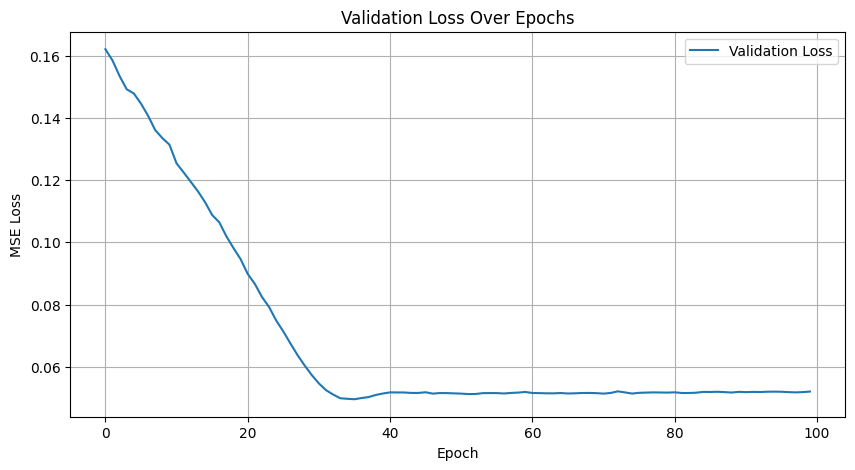

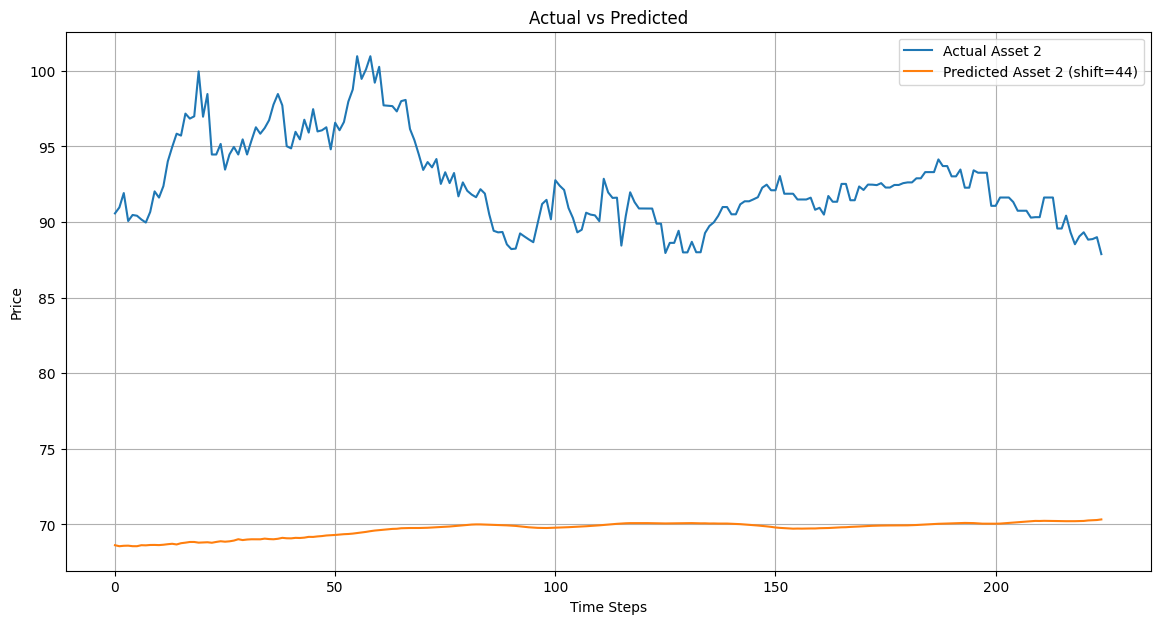

Test RMSE: 23.0934
Orthogonalization Regression Coefficients:
NeuralSDE: -4.3988
NG=F: 1.6323
IMOEX: 0.0106
Intercept: 361.1091
RMSE: 2.2486
Final Regression Coefficients:
OrthogRUB: -0.0001
NG=F: 0.0000
IMOEX: 0.0000
Intercept: 1.0038
RMSE: 0.0005


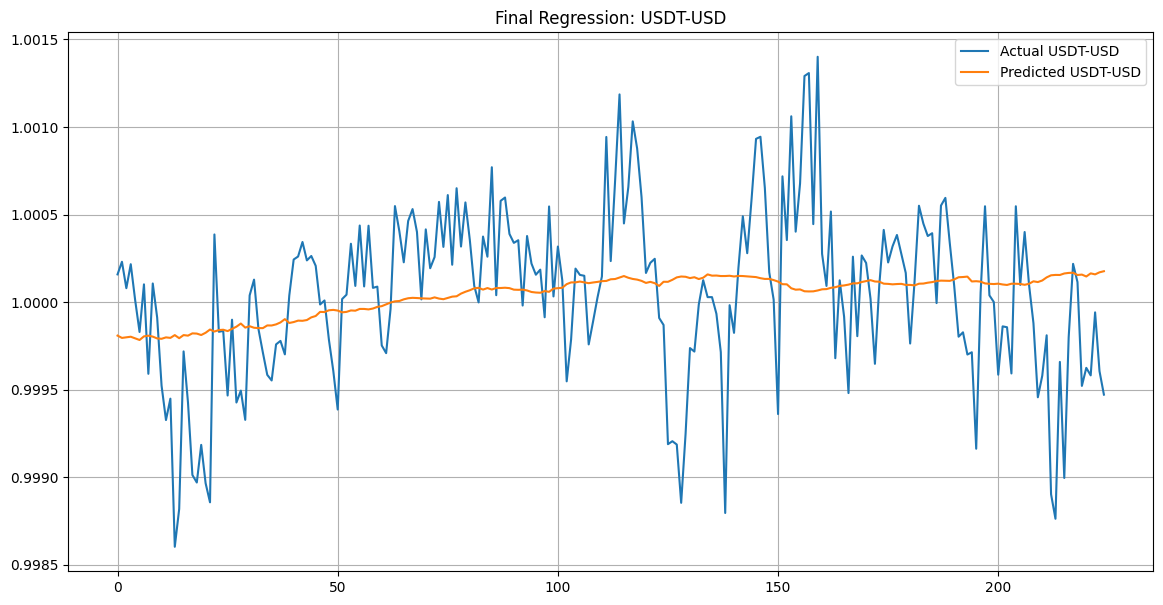

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pywt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define tickers
tickers = {
    'CL=F': 'CL=F',
    'NG=F': 'NG=F',
    'IMOEX.ME': 'IMOEX.ME',
    'RUB=X': 'RUB=X',
    'USDT-USD': 'USDT-USD'
}
start_date = '2017-04-01'
end_date = '2025-07-24'

# Download
df_all = {}
for k in tickers:
    df = yf.download(tickers[k], start=start_date, end=end_date, interval='1d', progress=False)[['Close']]
    df.columns = [k]
    df_all[k] = df

# Merge
df = pd.concat(df_all.values(), axis=1).dropna()
def wavelet_denoise(series, wavelet='db4', level=1):
    series = np.asarray(series).flatten()
    coeffs = pywt.wavedec(series, wavelet, level=level)
    coeffs[1:] = [pywt.threshold(c, value=0.5*np.std(c), mode='soft') for c in coeffs[1:]]
    rec = pywt.waverec(coeffs, wavelet)
    return rec[:len(series)]

for asset in ['CL=F', 'NG=F', 'IMOEX.ME']:
    df[f'{asset}_denoised'] = wavelet_denoise(df[asset])
model_df = pd.DataFrame({
    'Asset1': df['CL=F_denoised'].values,
    'Asset2': df['NG=F_denoised'].values,
    'Asset3': df['IMOEX.ME_denoised'].values,
    'Target': df['RUB=X'].values
}).dropna()
def preprocess_for_sde(df, lookback, time_step, batch_size=256, split_ratio=0.65):
    features = df[['Asset1', 'Asset2', 'Asset3']].values
    targets = df['Target'].values
    X_raw, y_raw = [], []
    for i in range(len(features) - lookback - time_step):
        X_raw.append(features[i:i+lookback])
        y_raw.append(targets[i+lookback+time_step])
    X_raw, y_raw = np.array(X_raw), np.array(y_raw).reshape(-1, 1)
    total_len = len(X_raw)
    train_idx = int(split_ratio * total_len)
    val_idx = int((split_ratio + (1 - split_ratio)/2) * total_len)
    X_train_raw, y_train_raw = X_raw[:train_idx], y_raw[:train_idx]
    X_val_raw, y_val_raw = X_raw[train_idx:val_idx], y_raw[train_idx:val_idx]
    X_test_raw, y_test_raw = X_raw[val_idx:], y_raw[val_idx:]

    feat_scaler = MinMaxScaler()
    tgt_scaler = MinMaxScaler()
    X_train = feat_scaler.fit_transform(X_train_raw.reshape(-1, 4)).reshape(X_train_raw.shape)
    X_val = feat_scaler.transform(X_val_raw.reshape(-1, 4)).reshape(X_val_raw.shape)
    X_test = feat_scaler.transform(X_test_raw.reshape(-1, 4)).reshape(X_test_raw.shape)
    y_train = tgt_scaler.fit_transform(y_train_raw)
    y_val = tgt_scaler.transform(y_val_raw)
    y_test = tgt_scaler.transform(y_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, X_test, y_test

LOOKBACK = 44
TIME_STEP = 1
BATCH_SIZE = 256
TRAIN_SPLIT = 0.65
EPOCHS = 100
HIDDEN_SIZE = 1024
LEARNING_RATE = 1e-5

train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, X_test, y_test = preprocess_for_sde(
    model_df, LOOKBACK, TIME_STEP, BATCH_SIZE, TRAIN_SPLIT
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralSDEWithJump(HIDDEN_SIZE, 3, 1, LOOKBACK).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS)
plot_val_loss(val_losses)

actual, predicted = evaluate_model(model, test_loader, tgt_scaler, device, lookback=LOOKBACK)
plot_results(actual, predicted, lookback=LOOKBACK)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare regression variables
ng = df['NG=F'].values[-len(actual):]
imoex = df['IMOEX.ME'].values[-len(actual):]


X_reg = np.column_stack([predicted, ng, imoex])
y_reg = actual

# Linear regression
reg = LinearRegression().fit(X_reg, y_reg)
y_pred_reg = reg.predict(X_reg)

print('Orthogonalization Regression Coefficients:')
for name, coef in zip(['NeuralSDE', 'NG=F', 'IMOEX'], reg.coef_[0] if hasattr(reg.coef_[0], '__iter__') else reg.coef_):
    print(f'{name}: {coef:.4f}')
print(f'Intercept: {reg.intercept_[0] if hasattr(reg.intercept_, "__iter__") else reg.intercept_:.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_reg, y_pred_reg)):.4f}')
usdt_prices = df['USDT-USD'].values[-len(y_pred_reg):]
X_final = np.column_stack([y_pred_reg, ng, imoex])
reg2 = LinearRegression().fit(X_final, usdt_prices)
y_pred_usdt = reg2.predict(X_final)

print('Final Regression Coefficients:')
for name, coef in zip(['OrthogRUB', 'NG=F', 'IMOEX'], reg2.coef_):
    print(f'{name}: {coef:.4f}')
print(f'Intercept: {reg2.intercept_:.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(usdt_prices, y_pred_usdt)):.4f}')

plt.figure(figsize=(14, 7))
plt.plot(usdt_prices, label='Actual USDT-USD')
plt.plot(y_pred_usdt, label='Predicted USDT-USD')
plt.title('Final Regression: USDT-USD')
plt.legend()
plt.grid(True)
plt.show()

from linearmodels.iv import IV2SLS
from scipy.stats import chi2
import pandas as pd
import numpy as np

# Prepare dataframe (ensure all columns are 1D arrays)
hausman_df = pd.DataFrame({
    'usdt': np.ravel(usdt_prices),
    'orthog_rub': np.ravel(y_pred_reg),         # final orthogonalized RUB
    'rub_hat': np.ravel(predicted),   # instrument: raw Neural SDE RUB prediction
    'ng': np.ravel(ng),
    'imoex': np.ravel(imoex)
}).dropna()

# 1. OLS regression: assume orthog_rub is exogenous
ols = IV2SLS.from_formula('usdt ~ 1 + orthog_rub + ng + imoex', data=hausman_df).fit()

# 2. IV regression: treat orthog_rub as endogenous, instrumented by rub_hat
iv = IV2SLS.from_formula('usdt ~ 1 + [orthog_rub ~ rub_hat] + ng + imoex', data=hausman_df).fit()

# 3. Hausman test
# Extract coefficients and covariance matrices
b_ols = ols.params[['orthog_rub', 'ng', 'imoex']].values
b_iv = iv.params[['orthog_rub', 'ng', 'imoex']].values
v_ols = ols.cov.loc[['orthog_rub', 'ng', 'imoex'], ['orthog_rub', 'ng', 'imoex']].values
v_iv = iv.cov.loc[['orthog_rub', 'ng', 'imoex'], ['orthog_rub', 'ng', 'imoex']].values

# Compute difference and test statistic
diff = b_iv - b_ols
cov_diff = v_iv - v_ols

try:
    stat = diff.T @ np.linalg.inv(cov_diff) @ diff
    df_h = len(diff)
    p_value = 1 - chi2.cdf(stat, df_h)

    print("\n--- Hausman Test ---")
    print(f"Test statistic: {stat:.4f}")
    print(f"Degrees of freedom: {df_h}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("❗ Reject null: OrthogRUB appears endogenous. IV is preferred.")
    else:
        print("✅ Fail to reject null: No evidence OrthogRUB is endogenous. OLS is fine.")
except np.linalg.LinAlgError:
    print("\n⚠️ Covariance difference matrix is singular. Hausman test not computable.")

In [8]:
from linearmodels.iv import IV2SLS
from scipy.stats import chi2
import pandas as pd
import numpy as np

# Prepare dataframe (ensure all columns are 1D arrays)
hausman_df = pd.DataFrame({
    'usdt': np.ravel(usdt_prices),
    'orthog_rub': np.ravel(y_pred_reg),         # final orthogonalized RUB
    'rub_hat': np.ravel(predicted),   # instrument: raw Neural SDE RUB prediction
    'ng': np.ravel(ng),
    'imoex': np.ravel(imoex)
}).dropna()

# 1. OLS regression: assume orthog_rub is exogenous
ols = IV2SLS.from_formula('usdt ~ 1 + orthog_rub + ng + imoex', data=hausman_df).fit()

# 2. IV regression: treat orthog_rub as endogenous, instrumented by rub_hat
iv = IV2SLS.from_formula('usdt ~ 1 + [orthog_rub ~ rub_hat] + ng + imoex', data=hausman_df).fit()

# 3. Hausman test
# Extract coefficients and covariance matrices
b_ols = ols.params[['orthog_rub', 'ng', 'imoex']].values
b_iv = iv.params[['orthog_rub', 'ng', 'imoex']].values
v_ols = ols.cov.loc[['orthog_rub', 'ng', 'imoex'], ['orthog_rub', 'ng', 'imoex']].values
v_iv = iv.cov.loc[['orthog_rub', 'ng', 'imoex'], ['orthog_rub', 'ng', 'imoex']].values

# Compute difference and test statistic
diff = b_iv - b_ols
cov_diff = v_iv - v_ols

try:
    stat = diff.T @ np.linalg.inv(cov_diff) @ diff
    df_h = len(diff)
    p_value = 1 - chi2.cdf(stat, df_h)

    print("\n--- Hausman Test ---")
    print(f"Test statistic: {stat:.4f}")
    print(f"Degrees of freedom: {df_h}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("❗ Reject null: OrthogRUB appears endogenous. IV is preferred.")
    else:
        print("✅ Fail to reject null: No evidence OrthogRUB is endogenous. OLS is fine.")
except np.linalg.LinAlgError:
    print("\n⚠️ Covariance difference matrix is singular. Hausman test not computable.")


--- Hausman Test ---
Test statistic: 0.0000
Degrees of freedom: 3
P-value: 1.0000
✅ Fail to reject null: No evidence OrthogRUB is endogenous. OLS is fine.


In [11]:
p_value

np.float64(0.9999999999995525)